In [1]:
import sys, os
sys.path.append('..')
sys.path.append('../..')

In [2]:
import autograd

In [3]:
import pickle

In [4]:
import pystan

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import autograd.numpy as np
#import pystan
from viabel import all_bounds
from viabel.vb import (mean_field_gaussian_variational_family,
                       mean_field_t_variational_family,
                       full_rank_gaussian_variational_family,
                       t_variational_family,
                       black_box_klvi,
                       black_box_klvi_pd,
                       black_box_klvi_pd2,
                       black_box_chivi,
                       make_stan_log_density,
                       adagrad_optimize
                      )
from experiments import (get_samples_and_log_weights, 
                         plot_history, 
                         plot_approx_and_exact_contours, 
                         check_approx_accuracy,
                         print_bounds)

from data_generator import (data_generator_linear)

sns.set_style('white')
sns.set_context('notebook', font_scale=2, rc={'lines.linewidth': 2})

In [6]:
from viabel.vb import  rmsprop_IA_optimize_with_rhat, adam_IA_optimize_with_rhat

# Linear regression model example

We will approximate the posterior for the simple 2D robust linear regression model
$$\beta_i \sim \mathcal{N}(0, 10)$$
$$y_n | x_n, \beta, \sigma \sim \mathcal{T}_{1000000}(\beta^\top x_n, 1).$$

We will use Stan to take care of compute log probabilities and gradients for us. 

In [7]:
regression_model_code = """data {
  int<lower=0> N;   // number of observations
  int<lower=0> D;   // number of observations
  matrix[N, D] x;   // predictor matrix
  vector[N] y;      // outcome vector
}
parameters {
  vector[D] beta;       // coefficients for predictors
}

model {
  beta ~ normal(0, 10);
  #y ~ student_t(10000000, x * beta, 1);  // likelihood
  y ~ normal( x * beta, 0.5);  // likelihood
}"""

In [8]:

try:
    sm = pickle.load(open('robust_reg_model_1.pkl', 'rb'))
except:
    sm = pystan.StanModel(model_code=regression_model_code, model_name='regression_model')
    with open('robust_reg_model_1.pkl', 'wb') as f:
        pickle.dump(sm, f)


We generate 25 observations from the model with $\beta = (-2, 1)$.

In [9]:
SEED=5040
np.random.seed(SEED)
beta_gen = np.array([-2, 1])
N = 100
k=10
x = np.random.randn(N, 2).dot(np.array([[1,.85],[.85, 1]]))
y_raw = x.dot(beta_gen) + np.random.standard_t(10, N)
y = y_raw - np.mean(y_raw)

In [10]:
N=200
k=20
SEED= 5080
alpha=1.
noise_sigma = 0.4
noise_var = noise_sigma**2
rho = 0.5
regression_data = data_generator_linear(N, k, alpha=alpha,
                                                     noise_variance=noise_var,
                                                     rho=rho, seed=SEED)
X = regression_data['X']
Y = regression_data['Y']
Y=Y[:,0]
W = regression_data['W']

First, we generate ground truth samples using Stan's dynamic HMC implementation

In [11]:
data = dict(N=N, x=X, y=Y, D=k)
fit = sm.sampling(data=data)

In [12]:
true_mean = np.mean(fit['beta'], axis=0)
true_cov = np.cov(fit['beta'].T)

In [13]:
true_std = np.sqrt(np.diag(true_cov))

In [14]:
print(true_mean)

[ 0.00966226 -0.37933686 -1.3231542   1.05718077 -1.4556044   2.1462135
 -0.43930396 -0.0972874   0.00980041 -0.55974507  1.7698318   0.45979368
 -0.11547845  0.04978967  0.73298924 -0.15057186 -0.48376235  0.20347726
  1.36052262  1.36514114]


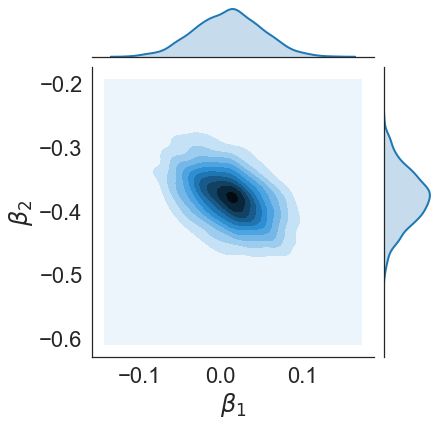

In [15]:
jp = sns.jointplot(x=fit['beta[1]'], y=fit['beta[2]'], kind='kde')
jp.set_axis_labels(r'$\beta_1$', r'$\beta_2$')
plt.show()

## Standard mean-field variational inference

Next, we compute a mean field variational approximation using standard variational inference (that is, minimizing the KL-divergence)

#### Here we will investigate if Iterate Averaging(IA) really improves estimation of variational parameters 
#### first with full  rank approximation and then mean field approximation on ELBO objective values.
#### We also show the effect of using path gradients, which always give a slightly better estimate of ELBO:

In [16]:
mf_g_var_family = mean_field_gaussian_variational_family(k)
fr_g_var_family = t_variational_family(k, df=1000000)

In [17]:
mf_g_var_family = mean_field_gaussian_variational_family(k)
stan_log_density = make_stan_log_density(fit)
klvi_mf_objective_and_grad = black_box_klvi(mf_g_var_family, stan_log_density, 100)
klvi_fr_objective_and_grad = black_box_klvi(fr_g_var_family, stan_log_density, 100)
init_mean    = np.zeros(k)
init_log_std = np.ones(k)
init_var_param = np.concatenate([init_mean, init_log_std])
n_iters = 5000



In [18]:
klvi_mf_objective_and_grad_pd = black_box_klvi_pd2(mf_g_var_family, stan_log_density, 100)
klvi_fr_objective_and_grad_pd = black_box_klvi_pd2(fr_g_var_family, stan_log_density, 100)
init_mean    = np.zeros(k)
#init_mean_random = np.random.normal([k], stddev=1.0)
init_log_std = np.ones(k)
#init_log_std_random = tf.random.normal([k], stddev=1.)
init_var_param = np.concatenate([init_mean, init_log_std])
init_fr_var_param = np.concatenate([init_mean, np.ones(int(k*(k+1)/2))])

####  First we use mean field Gaussian as proposal density

In [20]:
klvi_var_param_rms, klvi_var_param_list_rms, avg_klvi_var_param_list_rms, klvi_history_rms, _, op_log_mf_rms = \
    rmsprop_IA_optimize_with_rhat(7000, klvi_mf_objective_and_grad, init_var_param, k, learning_rate=.01,n_optimisers=1)

Average Loss = 92.1222: 100%|██████████| 7000/7000 [01:20<00:00, 86.69it/s] 


###### Iterations taken to converge to stationary distribution Brownian motion according to r-hat

In [21]:
print(op_log_mf_rms['start_avg_mean_iters'])
print(op_log_mf_rms['start_avg_sigma_iters'])

2000
5000


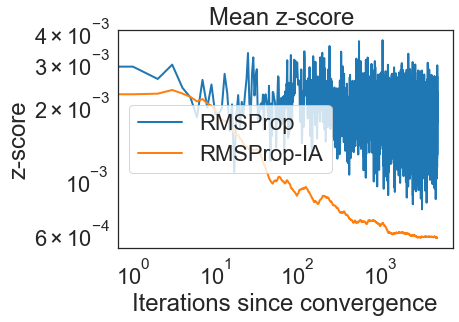

In [22]:
plt.loglog(np.mean(np.sqrt(np.square(klvi_var_param_list_rms[0][op_log_mf_rms['start_avg_mean_iters']:,:k] - true_mean)), axis=1), label='RMSProp')
plt.loglog(np.mean(np.sqrt(np.square(avg_klvi_var_param_list_rms[0][:,:k] - true_mean)), axis=1), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('z-score')
plt.title('Mean z-score ')
plt.legend()

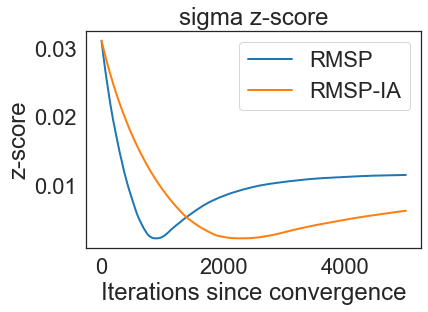

In [23]:
plt.plot(np.mean(np.sqrt(np.square(np.exp(klvi_var_param_list_rms[0][op_log_mf_rms['start_avg_mean_iters']:,k:]) - true_std)), axis=1), label='RMSP')
plt.plot(np.mean(np.sqrt(np.square(np.exp(avg_klvi_var_param_list_rms[0][:,k:]) - true_std)), axis=1), label='RMSP-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('z-score')
plt.title('sigma z-score')
plt.legend()

##### Same as above but with path gradients

In [24]:
klvi_var_param_rms_pd, klvi_var_param_list_rms_pd, avg_klvi_var_param_list_rms_pd, klvi_history_rms_pd, _, op_log_mf_rms_pd = \
    rmsprop_IA_optimize_with_rhat(7000, klvi_mf_objective_and_grad_pd, init_var_param, k, learning_rate=.01,n_optimisers=1)

Average Loss = 92.0925: 100%|██████████| 7000/7000 [01:39<00:00, 70.55it/s] 


###### Iterations taken to converge to stationary distribution Brownian motion according to r-hat

In [25]:
print(op_log_mf_rms_pd['start_avg_mean_iters'])
print(op_log_mf_rms_pd['start_avg_sigma_iters'])

1500
5000


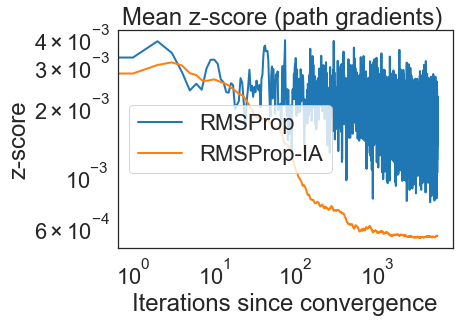

In [26]:
plt.loglog(np.mean(np.sqrt(np.square(klvi_var_param_list_rms_pd[0][op_log_mf_rms_pd['start_avg_mean_iters']:,:k] - true_mean)), axis=1), label='RMSProp')
plt.loglog(np.mean(np.sqrt(np.square(avg_klvi_var_param_list_rms_pd[0][:,:k] - true_mean)), axis=1), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('z-score')
plt.title('Mean z-score (path gradients) ')
plt.legend()

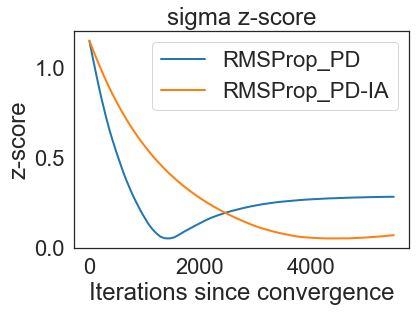

In [27]:
plt.plot(np.mean(np.sqrt(np.square(klvi_var_param_list_rms_pd[0][op_log_mf_rms_pd['start_avg_mean_iters']:,k:] - np.log(true_std))), axis=1), label='RMSProp_PD')
plt.plot(np.mean(np.sqrt(np.square(avg_klvi_var_param_list_rms_pd[0][:,k:] - np.log(true_std))), axis=1), label='RMSProp_PD-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('z-score')
plt.title('sigma z-score')
plt.legend()

### Now we use Full rank Gaussian as proposal density.

In [29]:
klvi_fr_var_param_rms, klvi_fr_var_param_list_rms, avg_klvi_fr_var_param_list_rms, fr_klvi_history_rms, _, op_log_fr_rms = \
    rmsprop_IA_optimize_with_rhat(13000, klvi_fr_objective_and_grad, init_fr_var_param, k, learning_rate=.01,n_optimisers=1, r_mean_threshold=1.15)

Average Loss = 117.36: 100%|██████████| 13000/13000 [04:11<00:00, 51.62it/s] 


In [ ]:
#klvi_fr_var_param_rms_pd, klvi_fr_var_param_list_rms_pd, avg_klvi_fr_var_param_list_rms_pd, fr_klvi_history_rms_pd, _, op_log_fr_rms_pd = \
#    rmsprop_IA_optimize_with_rhat(12000, klvi_fr_objective_and_grad_pd, init_fr_var_param, k, learning_rate=.01,n_optimisers=1, r_mean_threshold=1.15)

##### Iterations taken for convergence with RMSProp using R-hat fixed window statistic

In [30]:
print(op_log_fr_rms['start_avg_mean_iters'])
print(op_log_fr_rms['start_avg_sigma_iters'])

9000
11000


In [31]:
#print(op_log_fr_rms_pd['start_avg_mean_iters'])
#print(op_log_fr_rms_pd['start_avg_sigma_iters'])

#### Plot for evolution of difference between mean-parameter  and true mean after convergence detected by R-hat

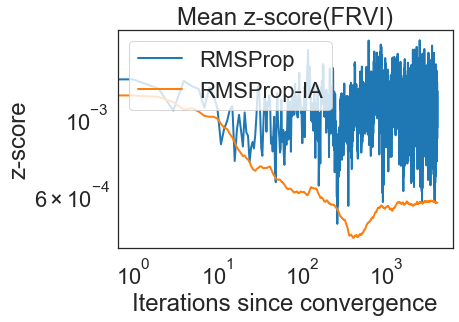

In [32]:
plt.loglog(np.mean(np.sqrt(np.square(klvi_fr_var_param_list_rms[0][op_log_fr_rms['start_avg_mean_iters']:,:k] - true_mean)), axis=1), label='RMSProp')
plt.loglog(np.mean(np.sqrt(np.square(avg_klvi_fr_var_param_list_rms[0][:,:k] - true_mean)), axis=1), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('z-score')
plt.title('Mean z-score(FRVI)')
plt.legend()

In [33]:
#plt.loglog(np.mean(np.sqrt(np.square(np.exp(klvi_fr_var_param_list_rms[0][op_log_fr_rms['start_avg_sigma_iters']:,k:]) - true_std)), axis=1), label='RMSP')
#plt.loglog(np.mean(np.sqrt(np.square(np.exp(avg_klvi_fr_var_param_list_rms[0][:,k:]) - true_std)), axis=1), label='RMSP-IA')
#plt.xlabel('Iterations since convergence')
#plt.ylabel('z-score')
#plt.title('Mean z-score')
#plt.legend()

### ADAM Optimiser
#### Same expts as above but with ADAM optimiser

In [42]:
klvi_var_param_adam, klvi_var_param_list_adam, avg_klvi_var_param_list_adam, klvi_history_adam, _, op_log_mf_adam = \
    adam_IA_optimize_with_rhat(13000, klvi_mf_objective_and_grad, init_var_param, k, learning_rate=.01,n_optimisers=1, r_mean_threshold=1.10)

Average Loss = 92.1882: 100%|██████████| 13000/13000 [02:49<00:00, 76.47it/s]


###### Iterations taken to converge to stationary distribution Brownian motion according to r-hat

In [43]:
print(op_log_mf_adam['start_avg_mean_iters'])
print(op_log_mf_adam['start_avg_sigma_iters'])

5000
11000


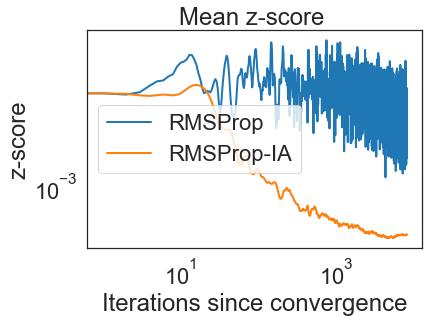

In [44]:
plt.loglog(np.mean(np.sqrt(np.square(klvi_var_param_list_adam[0][op_log_mf_adam['start_avg_mean_iters']:,:k] - true_mean)), axis=1), label='RMSProp')
plt.loglog(np.mean(np.sqrt(np.square(avg_klvi_var_param_list_adam[0][:,:k] - true_mean)), axis=1), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('z-score')
plt.title('Mean z-score ')
plt.legend()

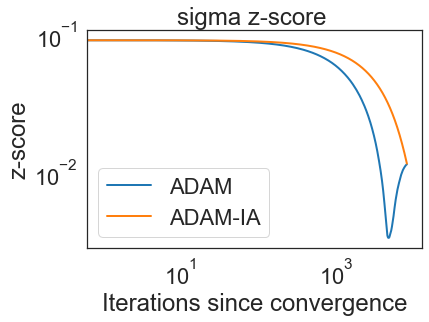

In [45]:
plt.loglog(np.mean(np.sqrt(np.square(np.exp(klvi_var_param_list_adam[0][op_log_mf_adam['start_avg_mean_iters']:,k:]) - true_std)), axis=1), label='ADAM')
plt.loglog(np.mean(np.sqrt(np.square(np.exp(avg_klvi_var_param_list_adam[0][:,k:]) - true_std)), axis=1), label='ADAM-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('z-score')
plt.title('sigma z-score ')
plt.legend()

In [38]:
klvi_var_param_adam_pd, klvi_var_param_list_adam_pd,  avg_klvi_var_param_list_adam_pd, klvi_history_adam_pd, _, op_log_adam_pd = \
    adam_IA_optimize_with_rhat(13000, klvi_mf_objective_and_grad_pd, init_var_param, k, learning_rate=.011, r_mean_threshold=1.02, n_optimisers=1)

Average Loss = 92.1573: 100%|██████████| 13000/13000 [33:25<00:00,  6.48it/s]   


In [39]:
print(op_log_adam_pd['start_avg_mean_iters'])
print(op_log_adam_pd['start_avg_sigma_iters'])

8500
11000


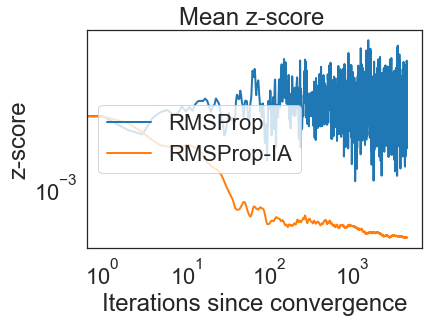

In [40]:
plt.loglog(np.mean(np.sqrt(np.square(klvi_var_param_list_adam_pd[0][op_log_adam_pd['start_avg_mean_iters']:,:k] - true_mean)), axis=1), label='RMSProp')
plt.loglog(np.mean(np.sqrt(np.square(avg_klvi_var_param_list_adam_pd[0][:,:k] - true_mean)), axis=1), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('z-score')
plt.title('Mean z-score ')
plt.legend()

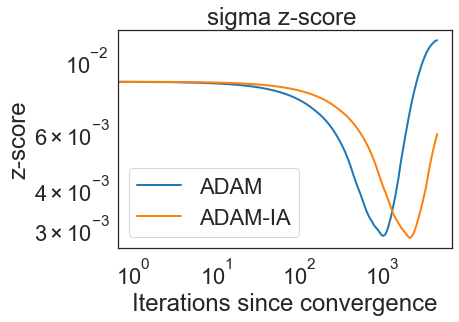

In [41]:
plt.loglog(np.mean(np.sqrt(np.square(np.exp(klvi_var_param_list_adam_pd[0][op_log_adam_pd['start_avg_mean_iters']:,k:]) - true_std)), axis=1), label='ADAM')
plt.loglog(np.mean(np.sqrt(np.square(np.exp(avg_klvi_var_param_list_adam_pd[0][:,k:]) - true_std)), axis=1), label='ADAM-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('z-score')
plt.title('sigma z-score ')
plt.legend()

In [46]:
klvi_fr_var_param_adam, klvi_fr_var_param_list_adam, avg_klvi_fr_var_param_list_adam, fr_klvi_history_adam, _, op_log_fr_adam = \
    adam_IA_optimize_with_rhat(19000, klvi_fr_objective_and_grad, init_fr_var_param, k, learning_rate=.01,n_optimisers=1, r_mean_threshold=1.15)

Average Loss = 118.359: 100%|██████████| 19000/19000 [05:42<00:00, 55.49it/s]


In [49]:
print(op_log_fr_adam['start_avg_mean_iters'])
print(op_log_fr_adam['start_avg_sigma_iters'])

8000
17000


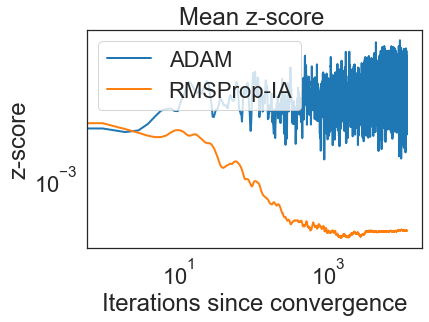

In [50]:
plt.loglog(np.mean(np.sqrt(np.square(klvi_fr_var_param_list_adam[0][op_log_fr_adam['start_avg_mean_iters']:,:k] - true_mean)), axis=1), label='ADAM')
plt.loglog(np.mean(np.sqrt(np.square(avg_klvi_fr_var_param_list_adam[0][:,:k] - true_mean)), axis=1), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('z-score')
plt.title('Mean z-score ')
plt.legend()

In [ ]:
plt.loglog(np.mean(np.sqrt(np.square(np.exp(klvi_var_param_list_adam_pd[0][op_log_adam_pd['start_avg_mean_iters']:,k:]) - true_std)), axis=1), label='ADAM')
plt.loglog(np.mean(np.sqrt(np.square(np.exp(avg_klvi_var_param_list_adam_pd[0][:,k:]) - true_std)), axis=1), label='ADAM-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('z-score')
plt.title('sigma z-score ')
plt.legend()

## Mean-field variational inference with CHIVI

We can repeat the same procedure, but this time using CHIVI and a Student t mean-field variational family. 